In [1]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import pandas as pd


In [ ]:
import gc
torch._C._cuda_emptyCache()
del u_out, v_out, p_out, f_out, g_out
gc.collect()

In [2]:
# check if GPU is available and use it; otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
torch.set_default_device(device)
torch.get_default_device()

device(type='cuda', index=0)

In [18]:
wind_0_path = 'data\\run_angle0\\export_postprocessing_U_DEM_bed_distance_1.0.csv'
wind0 = pd.read_csv(wind_0_path)
wind0 = wind0[wind0['Points_0']>0][wind0['Points_2']>0]

C:\Users\James\AppData\Local\Temp\ipykernel_16624\833387297.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wind0 = wind0[wind0['Points_0']>0][wind0['Points_2']>0]


In [4]:
nu = 0.01

#class NavierStokes(nn.Module):
class NavierStokes():
    def __init__(self, X, Y, T, u, v):
        #super().__init__() use this when inheiriting nn.Module
        self.x = torch.tensor(X, dtype=torch.float32, requires_grad=True)
        self.y = torch.tensor(Y, dtype=torch.float32, requires_grad=True)
        self.t = torch.tensor(T, dtype=torch.float32, requires_grad=True)

        self.u = torch.tensor(u, dtype=torch.float32)
        self.v = torch.tensor(v, dtype=torch.float32)

        #null vector to test against f and g:
        self.null = torch.zeros((self.x.shape[0], 1))
        
        # initialize network:
        self.network()

        self.optimizer = torch.optim.LBFGS(self.net.parameters(), lr=1, max_iter=20_000, max_eval=50000,
                                           history_size=50, tolerance_grad=1e-06, tolerance_change=0.5 * np.finfo(float).eps,
                                           line_search_fn="strong_wolfe")
        #deafault max_iter=200000

        self.mse = nn.MSELoss()

        #loss
        self.ls = 0

        #iteration number
        self.iter = 0

    def network(self):

        self.net = nn.Sequential(
            nn.Linear(3, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 2))

    def function(self, x, y, t):

        res = self.net(torch.hstack((x, y, t)))
        psi, p = res[:, 0:1], res[:, 1:2]

        u = torch.autograd.grad(psi, y, grad_outputs=torch.ones_like(psi), create_graph=True)[0] #retain_graph=True,
        v = -1.*torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0]

        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]

        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

        f = u_t + u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
        g = v_t + u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)

        return u, v, p, f, g
        #return u, v

    def closure(self):
        # reset gradients to zero:
        self.optimizer.zero_grad()

        # u, v, p, g and f predictions:
        u_prediction, v_prediction, p_prediction, f_prediction, g_prediction = self.function(self.x, self.y, self.t)

        # calculate losses
        u_loss = self.mse(u_prediction, self.u)
        v_loss = self.mse(v_prediction, self.v)
        f_loss = self.mse(f_prediction, self.null)
        g_loss = self.mse(g_prediction, self.null)
        self.ls = u_loss + v_loss + f_loss +g_loss

        # derivative with respect to net's weights:
        self.ls.backward()

        self.iter += 1
        if not self.iter % 5:
            print('Iteration: {:}, Loss: {:0.6f}'.format(self.iter, self.ls))

        return self.ls

    def train(self):

        # training loop
        self.net.train()
        self.optimizer.step(self.closure)

In [19]:
#Extracting data from dataframe
Points_0 = wind0['Points_0'].to_numpy() # horizontal coord [-350, 350]
Points_1 = wind0['Points_1'].to_numpy() # This is the height data - we omit for now
Points_2 = wind0['Points_2'].to_numpy() # depth coord [-200, 200]
pressure = wind0['p'].to_numpy()

U_0 = wind0['U_0'].to_numpy() # wind velocity in the Points_0 direction
U_1 = wind0['U_1'].to_numpy() # wind velocity in the Points_2 direction
U_2 = wind0['U_2'].to_numpy() # I think this is the verticle component - we omit for now

#sampling the available training data
N_train = 5000                           #number of data points sampeled
data_length = len(wind0)                 #all the data available to train on

idx = np.random.choice(data_length, N_train, replace=False)
x_train = Points_0[idx, None]
y_train = Points_2[idx, None]
#t_train = t[idx, :]                     #Ideally our data would be sampeled in time.. 
t_train = np.repeat(1,N_train)[:, None] # unfortunatly it is all at 1200s afaik but lets imagine it was sampled at 1 seconds
u_train = U_0[idx, None] 
v_train = U_2[idx, None]


pinn = NavierStokes(x_train, y_train, t_train, u_train, v_train)

pinn.train()

C:\Users\James\miniconda3\envs\thesis\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [5000, 1], strides() = [1, 0]
param.sizes() = [5000, 1], strides() = [1, 0] (Triggered internally at C:\cb\pytorch_1000000000000\work\torch/csrc/autograd/functions/accumulate_grad.h:219.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iteration: 5, Loss: 225.530502
Iteration: 10, Loss: 225.507080
Iteration: 15, Loss: 225.292282
Iteration: 20, Loss: 225.292282
Iteration: 25, Loss: 225.292282


In [20]:
x_test = Points_0[:, None]#.reshape(701, 401)
y_test = Points_1[:, None]#.reshape(701, 401)
p_test = pressure[:, None]#.reshape(701, 401)
u_test = U_0[:, None]#.reshape(701, 401)
#t_test = np.ones(data_length)[:, None]
t_test = np.ones((x_test.shape[0], x_test.shape[1]))

x_test = torch.tensor(x_test, dtype=torch.float32, requires_grad=True)
y_test = torch.tensor(y_test, dtype=torch.float32, requires_grad=True)
t_test = torch.tensor(t_test, dtype=torch.float32, requires_grad=True)

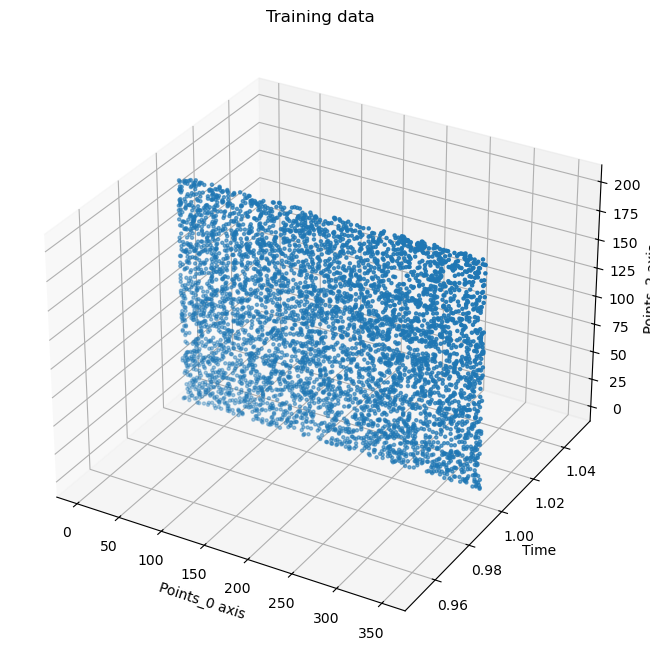

In [39]:
#Training data
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(projection='3d')
ax.scatter(x_train, t_train, y_train, marker='.')

ax.set_xlabel('Points_0 axis ')
ax.set_ylabel('Time')
ax.set_zlabel('Points_2 axis')
ax.set_title('Training data')

plt.show()

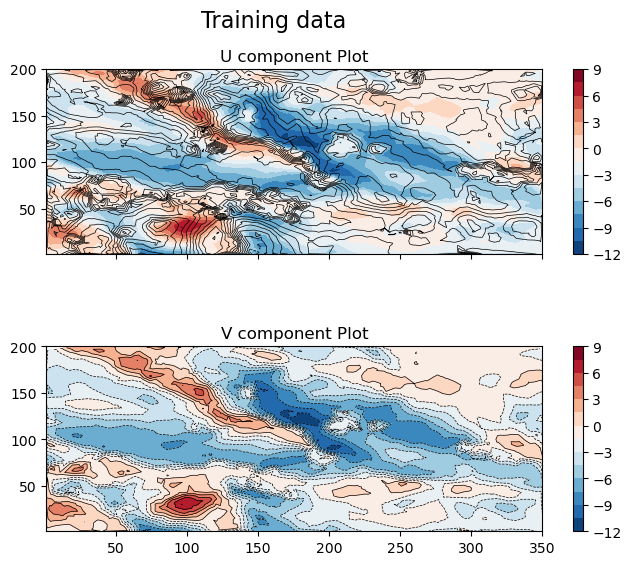

In [77]:
import matplotlib.tri as tri
fig, axs = plt.subplots(2,  figsize=(8,6), sharex=True, sharey=True)

axs[0].tricontour(x_train[:,0], y_train[:,0], u_train[:,0], levels=14, linewidths=0.5, colors='k')
cntr0 = axs[0].tricontourf(x_train[:,0], y_train[:,0], v_train[:,0], levels=14, cmap="RdBu_r")
fig.colorbar(cntr0, ax=axs[0])
axs[0].title.set_text('U component Plot')

axs[1].tricontour(x_train[:,0], y_train[:,0], v_train[:,0], levels=14, linewidths=0.5, colors='k')
cntr1 = axs[1].tricontourf(x_train[:,0], y_train[:,0], v_train[:,0], levels=14, cmap="RdBu_r")
fig.colorbar(cntr1, ax=axs[1])
axs[1].title.set_text('V component Plot')


fig.suptitle('Training data', fontsize=16, ha='right')
plt.subplots_adjust(hspace=0.5)
plt.show()

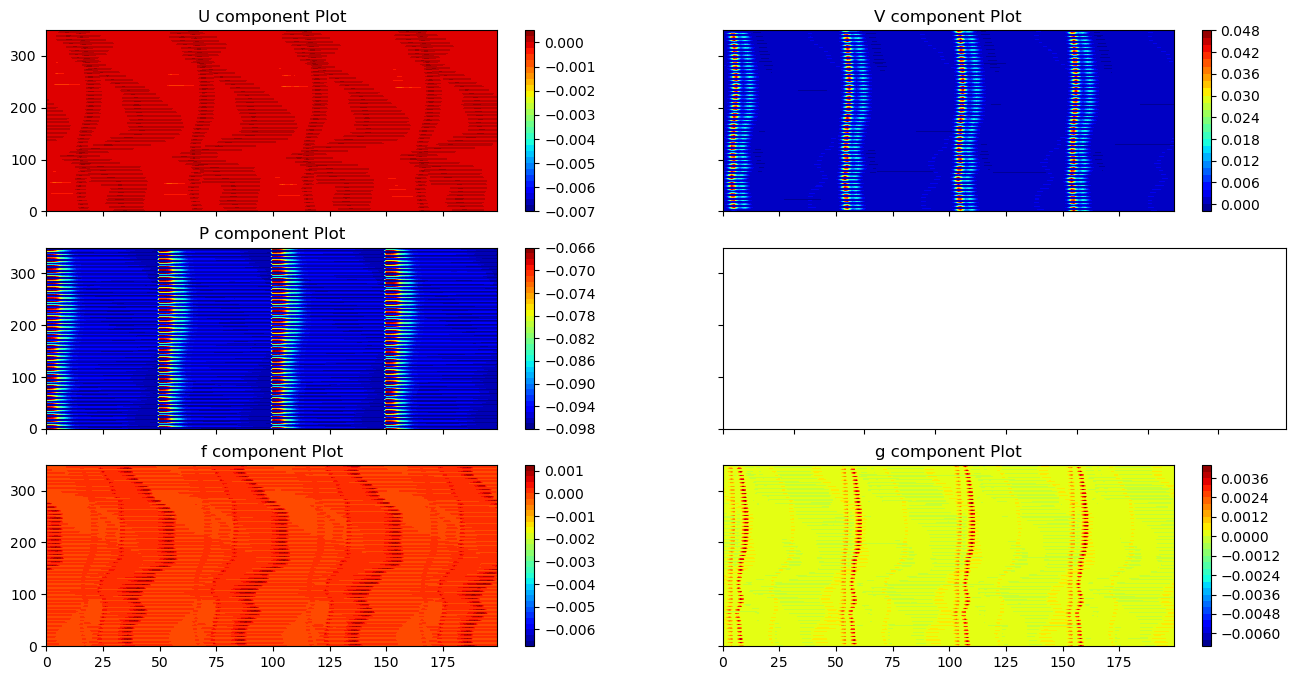

In [30]:
u_plot,v_plot, p_plot, f_plot, g_plot = [i.cpu().detach().numpy().reshape(350, 200) for i in pinn.function(x_test, y_test, t_test)]

fig, axs = plt.subplots(3,2,  figsize=(16,8), sharex=True, sharey=True)
p1 = axs[0,0].contourf(u_plot, levels=30, cmap='jet')
fig.colorbar(p1, ax=axs[0,0])
axs[0,0].title.set_text('U component Plot')


p2 = axs[0,1].contourf(v_plot, levels=30, cmap='jet')
fig.colorbar(p2, ax=axs[0,1])
axs[0,1].title.set_text('V component Plot')

p3 = axs[1,0].contourf(p_plot, levels=30, cmap='jet')
fig.colorbar(p3, ax=axs[1,0])
axs[1,0].title.set_text('P component Plot')

p4 = axs[2,0].contourf(f_plot, levels=30, cmap='jet')
fig.colorbar(p4, ax=axs[2,0])
axs[2,0].title.set_text('f component Plot')

p5 = axs[2,1].contourf(g_plot, levels=30, cmap='jet')
fig.colorbar(p5, ax=axs[2,1])
axs[2,1].title.set_text('g component Plot')
plt.show()

In [ ]:
#pinn = NavierStokes(x_train, y_train, t_train, u_train, v_train)
#pinn.net.load_state_dict(torch.load('model.pt'))

#pinn.net.eval()

#x_test = torch.tensor(x_test, dtype=torch.float32, requires_grad=True)
#y_test = torch.tensor(y_test, dtype=torch.float32, requires_grad=True)
#t_test = torch.tensor(t_test, dtype=torch.float32, requires_grad=True)

#u_out, v_out, p_out, f_out, g_out = pinn.function(x_test, y_test, t_test)
_, _, p_out, _, _ = pinn.function(x_test, y_test, t_test)

u_plot = p_out.data.cpu().numpy()
u_plot = np.reshape(u_plot, (701, 401))

fig, ax = plt.subplots()

plt.contourf(u_plot, levels=30, cmap='jet')
plt.colorbar()
#plt.show()

In [ ]:
#u_out, v_out, p_out, f_out, g_out

u_plot = u_out.data.to('cpu').numpy().reshape((50, 100))
v_plot = v_out.data.to('cpu').numpy().reshape((50, 100))
p_plot = p_out.data.to('cpu').numpy().reshape((50, 100))
f_plot = f_out.data.to('cpu').numpy().reshape((50, 100))
g_plot = g_out.data.to('cpu').numpy().reshape((50, 100))

fig, axs = plt.subplots(3,2,  figsize=(16,8), sharex=True, sharey=True)
p1 = axs[0,0].contourf(u_plot, levels=30, cmap='jet')
fig.colorbar(p1, ax=axs[0,0])
axs[0,0].title.set_text('U component Plot')


p2 = axs[0,1].contourf(v_plot, levels=30, cmap='jet')
fig.colorbar(p2, ax=axs[0,1])
axs[0,1].title.set_text('V component Plot')

p3 = axs[1,0].contourf(p_plot, levels=30, cmap='jet')
fig.colorbar(p3, ax=axs[1,0])
axs[1,0].title.set_text('P component Plot')

p4 = axs[2,0].contourf(f_plot, levels=30, cmap='jet')
fig.colorbar(p4, ax=axs[2,0])
axs[2,0].title.set_text('f component Plot')

p5 = axs[2,1].contourf(g_plot, levels=30, cmap='jet')
fig.colorbar(p5, ax=axs[2,1])
axs[2,1].title.set_text('g component Plot')

In [ ]:
u_plot.shape

In [ ]:
v_plot.shape